In [15]:
from dotenv import load_dotenv
import google.generativeai as genai
import zipfile
import os
import re

In [16]:
load_dotenv()

api_key = os.getenv("GEMINI_API_KEY")
genai.configure(api_key=api_key)
model = genai.GenerativeModel("gemini-2.5-flash")

In [24]:
with open(r"page_body_html.txt","r",encoding="utf-8") as h:
    texto_html = h.read()

In [37]:
import re

def filtrar_ruido_html(texto_html: str) -> str:
    """
    Reduce el tamaño del HTML eliminando comentarios, scripts y estilos
    con expresiones regulares.
    """
    # 1. Eliminar bloques de comentarios (HTML, JS, CSS)
    # Busca patrones como o /* ... */
    texto_html = re.sub(r'', '', texto_html, flags=re.DOTALL)

    # 2. Eliminar bloques de <script> (código JavaScript dinámico)
    # Se utiliza re.DOTALL para que '.' coincida con saltos de línea
    texto_html = re.sub(r'<script\b[^>]*>.*?</script>', '', texto_html, flags=re.DOTALL | re.IGNORECASE)

    # 3. Eliminar bloques de <style> (CSS)
    texto_html = re.sub(r'<style\b[^>]*>.*?</style>', '', texto_html, flags=re.DOTALL | re.IGNORECASE)

    # 4. Normalizar espacios (eliminar saltos de línea y reducir espacios múltiples)
    texto_html = re.sub(r'\s+', ' ', texto_html).strip()

    return texto_html

texto_html = filtrar_ruido_html(texto_html)

'<noscript><meta content="0;url=/httpservice/retry/enablejs?sei=FzYRacaSMbPR1sQPy7rYqA8" http-equiv="refresh"><div style="display:block">Haz clic <a href="/httpservice/retry/enablejs?sei=FzYRacaSMbPR1sQPy7rYqA8">aquí</a> si no vuelves a acceder en pocos segundos.</div></noscript><h1 class="bNg8Rb">Vínculos de accesibilidad</h1><div jscontroller="EufiNb" class="wYq63b"><div class="S6VXfe"><a jsname="BKxS1e" class="gyPpGe" role="link" tabindex="0" jsaction="i3viod" data-ved="0ahUKEwiG-pL9reaQAxWzqJUCHUsdFvUQ67oDCAU">Ir al contenido principal</a><a jsname="KI37ad" class="gyPpGe" href="https://support.google.com/websearch/answer/181196?hl=es-419" ping="/url?sa=t&amp;source=web&amp;rct=j&amp;url=https://support.google.com/websearch/answer/181196%3Fhl%3Des-419&amp;ved=0ahUKEwiG-pL9reaQAxWzqJUCHUsdFvUQwcMDCAY&amp;opi=89978449">Ayuda sobre la accesibilidad</a><div data-async-context="async_id:duf3-78;authority:0;card_id:;entry_point:0;feature_id:;ftoe:0;header:0;is_jobs_spam_form:0;open:0;pres
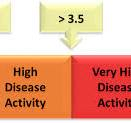
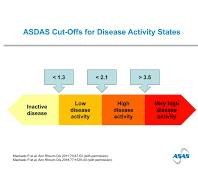
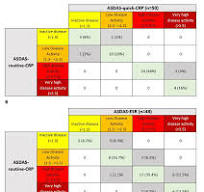
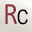
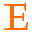

In [26]:
texto_html

In [27]:
with open(r"page_body_html_limpio.txt","w",encoding="utf-8") as archivo:
    archivo.write(texto_html)

In [36]:
def analizar_html(descripcion, codigo_html):
    """
    Genera descripciones de los elementos html.
    """
    
    mensaje = f"""
    Eres un **Analizador Experto de Estructuras HTML** y un **Ingeniero de Scrapeo (Web Scraping)**.

Tu tarea es inspeccionar el código HTML proporcionado, identificar la estructura de contenido clave y extraer los **identificadores (clases, IDs, selectores de atributos)** de los elementos más relevantes que representen bloques de contenido significativo (como videos, artículos, productos, enlaces de navegación, etc.).

Tu análisis debe enfocarse en cómo un desarrollador podría interactuar con estos elementos para una automatización o modificación específica (por ejemplo, una extensión de Chrome).

---

### 🔎 Parámetros de Entrada

**--- DESCRIPCION DE LA PÁGINA ---**
{descripcion.strip()}

**--- CÓDIGO HTML DE LA PÁGINA ---**
{codigo_html.strip()}

---

### 📋 Directrices de Extracción

1.  **Identificación de Bloques Repetitivos:** Identifica los selectores del **contenedor principal** que se repite en la página (ej. un contenedor de video, un artículo de noticias, una tarjeta de producto).
2.  **Utilidad y Descripción:** Para cada selector extraído, proporciona una descripción concisa de **qué representa** en la página (ej. "Contenedor de tarjeta de video individual," "Botón de 'Me gusta'").
3.  **Extracción de Sub-Elementos:** Dentro de cada bloque principal, extrae los selectores (clase o ID) de los elementos de información crucial (ej. título del video, enlace del autor, precio del producto).
4.  **Sintaxis de Selectores (CRUCIAL):** **Utiliza la sintaxis de selectores de CSS estándar** (ej. `.clase-ejemplo` para clases o `#id-ejemplo` para IDs). Si un elemento no tiene clase ni ID, indica una ruta de selector CSS clara (ej. `div > a[data-yt-id]`).

### 💡 Formato de Salida

Devuelve **únicamente** el análisis estructurado en formato de texto plano y legible, **sin preámbulos, explicaciones o texto adicional**, utilizando el siguiente formato de lista jerárquica:

    """

    respuesta = model.generate_content(mensaje)
    return respuesta.text

In [29]:
respuesta = analizar_html("este es el codigo html de un sitio de videos en su pagina principal en donde esta contiene varios videos",texto_html)

In [30]:
print(respuesta)

- **Bloque Principal de Contenido Multimedia (Tarjeta de Video/Imagen):**
    -   **Selector:** `div.vCUuC.m3LIae`
    -   **Descripción:** Contenedor principal de una tarjeta individual que representa un resultado de video o imagen.
    -   **Elementos Secundarios:**
        -   **Enlace a la Página del Contenido:**
            -   **Selector:** `a.ddkIM.c30Ztd`
            -   **Descripción:** El enlace principal que dirige a la página de destino del contenido multimedia.
        -   **Miniatura del Contenido (Thumbnail):**
            -   **Selector:** `div.gdOPf.uhHOwf.ez24Df > img`
            -   **Descripción:** La imagen en miniatura que representa visualmente el video o la imagen.
        -   **Título/Descripción del Contenido:**
            -   **Selector:** `div.yVCOtc.CvgGZ.LJEGod.t6uYac > span.Yt787.JGD2rd`
            -   **Descripción:** El título o una breve descripción textual del contenido multimedia.
        -   **Fuente/Dominio del Contenido:**
            -   **Sel

In [31]:
def extension_a_texto(carpeta):
    """
    Convierte todos los archivos de una carpeta (por ejemplo una extensión de Chrome)
    a un string en el formato esperado por el generador de extensiones.
    """
    bloques = []
    
    for root, _, files in os.walk(carpeta):
        for archivo in files:
            ruta = os.path.join(root, archivo)
            with open(ruta, "r", encoding="utf-8", errors="ignore") as f:
                contenido = f.read()
            
            # Obtenemos la ruta relativa (por si hay subcarpetas)
            ruta_relativa = os.path.relpath(ruta, carpeta)
            
            bloque = f"--- archivo: {ruta_relativa} ---\n{contenido}\n--- fin archivo ---"
            bloques.append(bloque)
    
    return "\n\n".join(bloques)


In [32]:
def generar_archivos_extension(codigo_completo, ruta_salida="extension_generada"):
    """
    Genera los archivos de una extensión de Chrome a partir del formato:
    
    --- archivo: nombre ---
    contenido
    --- fin archivo ---
    """
    os.makedirs(ruta_salida, exist_ok=True)

    patron = re.compile(
        r"---\s*archivo:\s*(.*?)\s*---\s*(.*?)\s*---\s*fin\s*archivo\s*---",
        re.DOTALL
    )

    matches = patron.findall(codigo_completo)

    if not matches:
        print("No se encontraron archivos en el texto.")
        return

    for nombre, contenido in matches:
        ruta_archivo = os.path.join(ruta_salida, nombre.strip())
        os.makedirs(os.path.dirname(ruta_archivo), exist_ok=True)
        with open(ruta_archivo, "w", encoding="utf-8") as f:
            f.write(contenido.strip())
        print(f"✅ Archivo generado: {ruta_archivo}")

    carpeta_origen = ruta_salida #r"\extension_generada"

    carpeta_salida = os.getcwd()  # usa os.getcwd() si estás en Jupyter

    # Nombre del ZIP basado en el nombre de la carpeta
    nombre_zip = os.path.basename(carpeta_origen.rstrip("\\/")) + ".zip"
    ruta_zip = os.path.join(carpeta_salida, nombre_zip)

    # Crear el ZIP
    with zipfile.ZipFile(ruta_zip, 'w', zipfile.ZIP_DEFLATED) as zipf:
        for raiz, _, archivos in os.walk(carpeta_origen):
            for archivo in archivos:
                ruta_completa = os.path.join(raiz, archivo)
                ruta_relativa = os.path.relpath(ruta_completa, carpeta_origen)
                zipf.write(ruta_completa, ruta_relativa)

    print(f"ZIP creado en: {ruta_zip}")

In [33]:
def generar_extension(prompt_principal, identificadores=None, codigo_referencia=None):
    """
    Genera el código de una extensión de Google Chrome en base a un prompt e información adicional.
    """
    
    mensaje = f""" Eres un **Generador Experto de Extensiones de Google Chrome (Manifest V3)**.

Tu objetivo es crear una extensión de Chrome **completamente funcional, segura y lista para cargar**, basándote rigurosamente en las instrucciones proporcionadas.

### Directrices Clave de Generación

1.  **Seguridad y Manifest V3 (CRUCIAL):**
    * **NO** se debe utilizar código JavaScript *inline* (ej. `<script>...</script>`) en archivos HTML (como `popup.html`). Todo JavaScript debe estar en archivos `.js` externos.
    * El archivo `manifest.json` debe estar configurado para **Manifest V3** y cumplir con las políticas de seguridad (CSP).
    * **NO** se debe hacer referencia a iconos, imágenes, fuentes o cualquier archivo externo que no esté estrictamente incluido en el código fuente de la respuesta.
2.  **Archivos:** Los archivos generados deben ser **autocontenidos** y **funcionales**.
3.  **Salida Estricta:** La respuesta debe contener **solamente** el código fuente de la extensión, **sin preámbulos, explicaciones, comentarios o texto adicional**.

---

### Parámetros de Extensión

**--- Instrucciones Principales (Función de la Extensión) ---**
{prompt_principal.strip()}

**--- Identificadores o Clases Relevantes (Sugerencias de CSS/HTML) ---**
{identificadores if identificadores else 'Ninguno especificado.'}

**--- Código de Referencia para Adaptar (Si aplica) ---**
{codigo_referencia if codigo_referencia else 'No se adjuntó código de referencia.'}

---

### Formato de Salida

Devuelve **únicamente** el código fuente, respetando **exactamente** el siguiente formato de bloques:

--- archivo: manifest.json ---
(contenido completo del archivo)
--- fin archivo ---

--- archivo: background.js ---
(contenido completo del archivo)
--- fin archivo ---

--- archivo: popup.html ---
(contenido completo del archivo, con el script JS enlazado externamente)
--- fin archivo ---

*(Incluye otros archivos, como `.js` o `.css`, solo si son necesarios para la funcionalidad, siguiendo el mismo formato de bloque.)*

--- archivo: popup.js ---
(contenido completo del archivo JS externo para popup.html)
--- fin archivo ---
. """

    respuesta = model.generate_content(mensaje)
    generar_archivos_extension(respuesta.text)
    return respuesta.text

In [34]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import zipfile
import io

def crear_campo(titulo, placeholder=''):
    etiqueta = widgets.HTML(f"<b>{titulo}</b>")
    area = widgets.Textarea(
        placeholder=placeholder,
        layout=widgets.Layout(flex='1', width='auto', height='120px', overflow='hidden')
    )
    box = widgets.VBox(
        [etiqueta, area],
        layout=widgets.Layout(flex='1 1 0', margin='0 5px 0 5px', min_width='0')
    )
    return box, area

# --- Campos ---
prompt_box, prompt_input = crear_campo("Prompt", "Escribe el prompt aquí...")
identificadores_box, identificadores_input = crear_campo("Identificadores", "Identificadores o etiquetas...")

# --- Archivo ZIP ---
codigo_ref_input = widgets.FileUpload(
    accept='.zip',
    multiple=False,
    description='Subir ZIP de referencia'
)

# --- Etiqueta del archivo cargado ---
nombre_archivo_label = widgets.Label(value="Ningún archivo seleccionado")

def on_file_upload(change):
    value = codigo_ref_input.value
    if value:
        # Detectar si es un dict o una tupla
        if isinstance(value, dict):
            nombre = list(value.keys())[0]
        elif isinstance(value, tuple):
            nombre = value[0]['name']
        else:
            nombre = "Archivo desconocido"
        nombre_archivo_label.value = f"Archivo cargado: {nombre}"
    else:
        nombre_archivo_label.value = "Ningún archivo seleccionado"

codigo_ref_input.observe(on_file_upload, names='value')

# --- Botón y salida ---
boton = widgets.Button(
    description='Generar extensión',
    button_style='success',
    icon='rocket',
    layout=widgets.Layout(width='200px', margin='10px 0px 0px 0px')
)
salida = widgets.Output()

def on_button_click(b):
    with salida:
        clear_output()
        prompt = prompt_input.value.strip()
        identificadores = identificadores_input.value.strip() or None

        if not prompt:
            print("Error: el campo 'prompt' es obligatorio.")
            return

        zip_data = None
        if codigo_ref_input.value:
            value = codigo_ref_input.value
            if isinstance(value, dict):
                archivo = list(value.values())[0]
            elif isinstance(value, tuple):
                archivo = value[0]
            else:
                archivo = None

            if archivo:
                contenido = io.BytesIO(archivo['content'])
                zip_data = zipfile.ZipFile(contenido)

        resultado = generar_extension(
            prompt,
            identificadores,
            zip_data
        )
        print(resultado)

boton.on_click(on_button_click)

# --- Layout ---
fila_inputs = widgets.HBox(
    [prompt_box, identificadores_box],
    layout=widgets.Layout(display='flex', flex_flow='row', width='100%')
)

layout_final = widgets.VBox([
    fila_inputs,
    widgets.HTML("<b>Código de referencia:</b>"),
    codigo_ref_input,
    nombre_archivo_label,  # <- muestra el nombre del archivo cargado
    boton,
    salida
], layout=widgets.Layout(width='100%'))

display(layout_final)


In [ ]:
import ipywidgets as widgets
from IPython.display import display, clear_output
import zipfile
import io
import re 
import time


# --- FUNCIÓN BASE DE CREACIÓN DE CAMPO ---
def crear_campo(titulo, placeholder=''):
    etiqueta = widgets.HTML(f"<b>{titulo}</b>")
    area = widgets.Textarea(
        placeholder=placeholder,
        layout=widgets.Layout(flex='1', width='auto', height='120px', overflow='hidden')
    )
    box = widgets.VBox(
        [etiqueta, area],
        layout=widgets.Layout(flex='1 1 0', margin='0 5px 0 5px', min_width='0')
    )
    return box, area

# --- CAMPOS PRINCIPALES ---
prompt_box, prompt_input = crear_campo("Prompt", "Escribe el prompt aquí...")
identificadores_box, identificadores_input = crear_campo("Identificadores", "Identificadores o etiquetas (se rellenará automáticamente al analizar el HTML).")
descripcion_box, descripcion_input = crear_campo("Descripción del HTML", "Describe el propósito de la página o del fragmento (ej: 'Página de inicio de YouTube').")

# --- INPUT DE ARCHIVO HTML ---
html_ref_input = widgets.FileUpload(
    accept='.txt',
    multiple=False,
    description='Subir fragmento HTML (.txt)'
)
html_archivo_label = widgets.Label(value="Ningún archivo HTML seleccionado")

def on_html_file_upload(change):
    value = html_ref_input.value
    if value:
        nombre = list(value.keys())[0] if isinstance(value, dict) else "Archivo cargado"
        html_archivo_label.value = f"Archivo cargado: {nombre}"
    else:
        html_archivo_label.value = "Ningún archivo HTML seleccionado"

html_ref_input.observe(on_html_file_upload, names='value')

# --- BOTÓN DE PROCESAMIENTO Y SALIDA ---
boton_procesar = widgets.Button(
    description='Procesar HTML y Rellenar Identificadores',
    button_style='info',
    icon='search',
    layout=widgets.Layout(width='300px', margin='10px 0px 10px 0px')
)
salida_procesamiento = widgets.Output()

def on_procesar_click(b):
    with salida_procesamiento:
        clear_output()
        
        descripcion = descripcion_input.value.strip()
        
        if not html_ref_input.value:
            print("❌ Error: Por favor, sube un archivo HTML (.txt) primero.")
            return
        
        if not descripcion:
            print("❌ Error: El campo 'Descripción del HTML' es obligatorio para el análisis.")
            return

        try:
            # LÓGICA DE LECTURA DE ARCHIVO MEJORADA
            file_value = html_ref_input.value
            
            if isinstance(file_value, dict):
                archivo_info = list(file_value.values())[0]
            elif isinstance(file_value, tuple):
                archivo_info = file_value[0]
            else:
                print("❌ Error: Formato de archivo subido desconocido.")
                return

            # Obtiene el contenido que puede ser 'bytes' o 'memoryview'
            contenido_bruto = archivo_info['content']
            
            # 📌 CORRECCIÓN CLAVE: Convertir explícitamente a bytes antes de decodificar
            # Si ya es bytes, esto no cambia nada. Si es memoryview, lo convierte a bytes.
            contenido_bytes = bytes(contenido_bruto)
            
            html_content = contenido_bytes.decode('utf-8')
            # ----------------------------------------------------

            print("1/3. 🔪 Filtrando ruido del HTML...")
            texto_html_filtrado = filtrar_ruido_html(html_content)
            
            if not texto_html_filtrado:
                 print("❌ Error: El archivo HTML quedó vacío después del filtrado. Verifica el contenido.")
                 return

            print("2/3. 🔎 Analizando HTML filtrado con el modelo (puede tardar unos segundos)...")
            resultado_analisis = analizar_html(descripcion, texto_html_filtrado)
            
            identificadores_input.value = resultado_analisis
            print("✅ 3/3. Análisis completado. El campo 'Identificadores' ha sido rellenado (revísalo y ajústalo si es necesario).")
            
        except Exception as e:
            # Captura cualquier otro error
            print(f"❌ Error durante el procesamiento: {e}")

boton_procesar.on_click(on_procesar_click)

# --- CÓDIGO DE REFERENCIA ZIP ---
codigo_ref_input = widgets.FileUpload(
    accept='.zip',
    multiple=False,
    description='Subir ZIP de referencia'
)
nombre_zip_label = widgets.Label(value="Ningún archivo seleccionado")

def on_zip_file_upload(change):
    value = codigo_ref_input.value
    if value:
        nombre = list(value.keys())[0] if isinstance(value, dict) else "Archivo cargado"
        nombre_zip_label.value = f"Archivo cargado: {nombre}"
    else:
        nombre_zip_label.value = "Ningún archivo seleccionado"

codigo_ref_input.observe(on_zip_file_upload, names='value')

# --- BOTÓN DE GENERACIÓN FINAL ---
boton_generar = widgets.Button(
    description='Generar extensión',
    button_style='success',
    icon='rocket',
    layout=widgets.Layout(width='200px', margin='10px 0px 0px 0px')
)
salida_generacion = widgets.Output()

def generar_extension(prompt, identificadores, zip_data):
    time.sleep(1)
    codigo_ref_info = "Sí, ZIP cargado." if zip_data else "No se proporcionó código de referencia."
    return (
        "--- RESULTADO DE LA GENERACIÓN ---\n"
        f"Prompt: {prompt[:50]}...\n"
        f"Identificadores: {identificadores or 'N/A'}\n"
        f"Código de Ref: {codigo_ref_info}\n"
        "\n[Aquí iría el código fuente completo de la extensión...]"
    )

def on_generar_click(b):
    with salida_generacion:
        clear_output()
        prompt = prompt_input.value.strip()
        identificadores = identificadores_input.value.strip() or None 

        if not prompt:
            print("❌ Error: el campo 'Prompt' es obligatorio.")
            return

        zip_data = None
        if codigo_ref_input.value:
            try:
                # Lógica de lectura simplificada para ZIP
                archivo_info = list(codigo_ref_input.value.values())[0]
                contenido = io.BytesIO(archivo_info['content'])
                zip_data = zipfile.ZipFile(contenido)
            except Exception as e:
                print(f"❌ Error al leer o abrir el archivo ZIP: {e}")
                return

        print("⌛ Iniciando la generación de la extensión...")
        resultado = generar_extension(
            prompt,
            identificadores,
            zip_data
        )
        print(resultado)

boton_generar.on_click(on_generar_click)

# --- LAYOUT FINAL ---

html_upload_group = widgets.VBox([
    widgets.HTML("<b>Subir fragmento HTML (.txt):</b>"), 
    widgets.HBox([html_ref_input, html_archivo_label], layout=widgets.Layout(align_items='center')) 
])

analisis_inputs_row = widgets.HBox([
    descripcion_box, 
    html_upload_group 
], layout=widgets.Layout(display='flex', flex_flow='row', width='100%', align_items='flex-start'))

layout_html_proc = widgets.VBox([
    widgets.HTML("<b>1. Análisis Estructural de HTML:</b>"),
    analisis_inputs_row,
    boton_procesar,
    salida_procesamiento
])

fila_inputs = widgets.HBox(
    [prompt_box, identificadores_box],
    layout=widgets.Layout(display='flex', flex_flow='row', width='100%')
)

layout_zip_ref = widgets.VBox([
    widgets.HTML("<b>2. Código de referencia ZIP (Opcional):</b>"),
    codigo_ref_input,
    nombre_zip_label,
])

layout_final = widgets.VBox([
    layout_html_proc,
    fila_inputs,
    layout_zip_ref,
    widgets.HTML("<b>3. Generación Final:</b>"),
    boton_generar,
    salida_generacion
], layout=widgets.Layout(width='100%'))

display(layout_final)